## Validação dos pseudo-neagtivos com Random Forest

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, average_precision_score


In [3]:
df = pd.read_csv('dataset_final_para_modelo_1_100.csv', decimal=",")
df

,latitude,longitude,data,dia_semana,mes,is_weekend,hora,Sinistro,Chuva,tipo_via_num,tp_veiculo_bicicleta,tp_veiculo_caminhao,tp_veiculo_motocicleta,tp_veiculo_nao_disponivel,tp_veiculo_onibus,tp_veiculo_outros,tp_veiculo_automovel
0,-22.323152,-49.066030,2022-10-24,0,10,0,23,0,0,0.0,0,0,0,0,0,0,1
1,-22.330302,-49.106223,2023-03-02,3,3,0,12,0,0,0.0,0,0,0,0,0,0,1
2,-22.335932,-49.067196,2025-01-08,2,1,0,17,0,0,0.0,0,0,0,0,0,0,1
3,-22.327175,-49.116669,2024-01-23,1,1,0,19,0,0,0.0,0,0,0,0,0,0,1
4,-22.330951,-49.088352,2022-09-19,0,9,0,20,0,0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827084,-22.309319,-49.073527,2025-01-16,3,1,0,15,0,0,0.0,0,0,1,0,0,0,0
827085,-22.325896,-49.079704,2024-05-17,4,5,0,9,0,0,0.0,0,0,0,0,0,0,1
827086,-22.351893,-49.032062,2024-02-01,3,2,0,13,0,0,0.0,0,0,0,0,0,0,1
827087,-22.291783,-49.071040,2022-07-10,6,7,1,9,0,0,0.0,0,0,0,0,0,0,1


### Separação de Features (X) e Alvo (y)

In [4]:
X = df.drop(columns=['Sinistro', 'data']) 

y = df['Sinistro']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=8, stratify=y
)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

Tamanho do conjunto de treino: (578962, 15)
Tamanho do conjunto de teste: (248127, 15)


### GridSearchCV

In [11]:
rf_base = RandomForestClassifier(
    random_state=8,
    class_weight='balanced',
    n_jobs=-1,
)

param_grid_rf = {
    'n_estimators': [200, 300, 400],          
    'max_depth': [10, 20, None], # Profundidade (None = até o fim)
    'min_samples_leaf': [2, 4, 6],          
    'min_samples_split': [5, 10, 15]         
}

grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    scoring='average_precision', # Otimiza para PR-AUC
    cv=3,
    verbose=0
)

print("Iniciando GridSearchCV para Random Forest...")
grid_search_rf.fit(X_train, y_train)

print("Busca concluída.")
print("\nMelhores parâmetros encontrados:")
print(grid_search_rf.best_params_)
print("\nMelhor score (Average Precision):")
print(grid_search_rf.best_score_)

Iniciando GridSearchCV para Random Forest...
Busca concluída.

Melhores parâmetros encontrados:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}

Melhor score (Average Precision):
0.8573188337006196


### Treinamento do Random Forest

In [5]:
final_rf_model = RandomForestClassifier(
    random_state=8,
    class_weight='balanced',
    n_jobs=-1,
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=5
)

final_rf_model.fit(X_train, y_train)

,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Fazer previsões e avaliar as métricas


--- Métricas Gerais ---
ROC-AUC: 0.9661
PR-AUC (Average Precision): 0.8606

--- Curva Precision-Recall (PR-AUC) ---


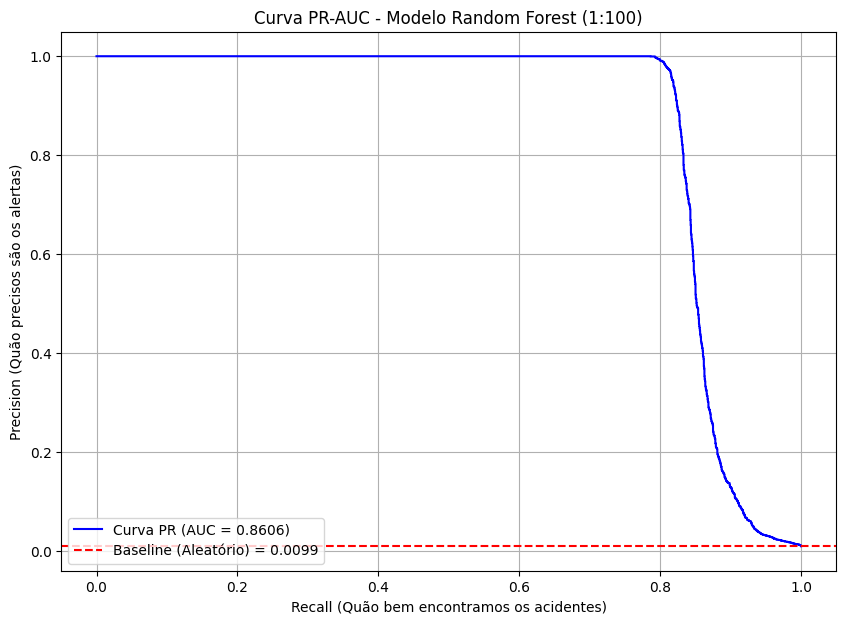

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    245670
           1       0.98      0.81      0.89      2457

    accuracy                           1.00    248127
   macro avg       0.99      0.90      0.94    248127
weighted avg       1.00      1.00      1.00    248127


--- Matriz de Confusão ---


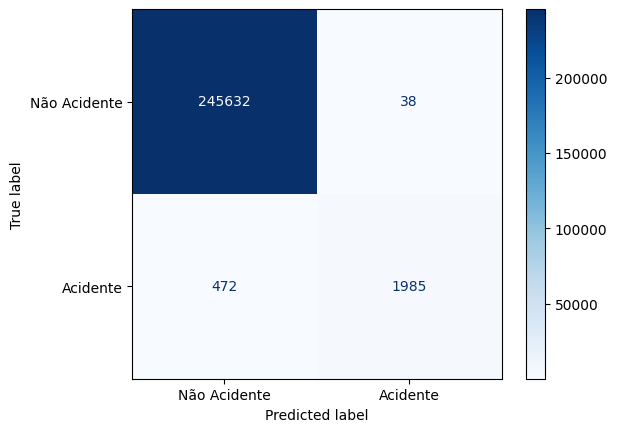

In [9]:
y_prob_rf = final_rf_model.predict_proba(X_test)[:, 1]

# Métricas Gerais (ROC-AUC e PR-AUC)
roc_auc = roc_auc_score(y_test, y_prob_rf)
pr_auc = average_precision_score(y_test, y_prob_rf)

print(f"\n--- Métricas Gerais ---")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (Average Precision): {pr_auc:.4f}")

# 4. Plotar a Curva PR-AUC
print("\n--- Curva Precision-Recall (PR-AUC) ---")
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob_rf)
pr_auc_plot = auc(recall, precision)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, color='b', label=f'Curva PR (AUC = {pr_auc_plot:.4f})')

# Linha de Base (Baseline)
n_positivos = y_test.sum()
n_total = len(y_test)
baseline = n_positivos / n_total
plt.axhline(y=baseline, color='r', linestyle='--', label=f'Baseline (Aleatório) = {baseline:.4f}')

plt.title('Curva PR-AUC - Modelo Random Forest (1:100)')
plt.xlabel('Recall (Quão bem encontramos os acidentes)')
plt.ylabel('Precision (Quão precisos são os alertas)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

LIMIAR_FINAL = 0.5


y_pred_rf = (y_prob_rf >= LIMIAR_FINAL).astype(int)
print(classification_report(y_test, y_pred_rf))

print("\n--- Matriz de Confusão ---")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf,
                                        cmap=plt.cm.Blues, 
                                        display_labels=['Não Acidente', 'Acidente'])
plt.show()

### SHAP (Shapley Additive exPlanations)

PermutationExplainer explainer: 12285it [17:01:34,  4.99s/it]                                   
C:\Users\pirsp\AppData\Local\Temp\ipykernel_21692\1063239192.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, max_display=15, show=True)


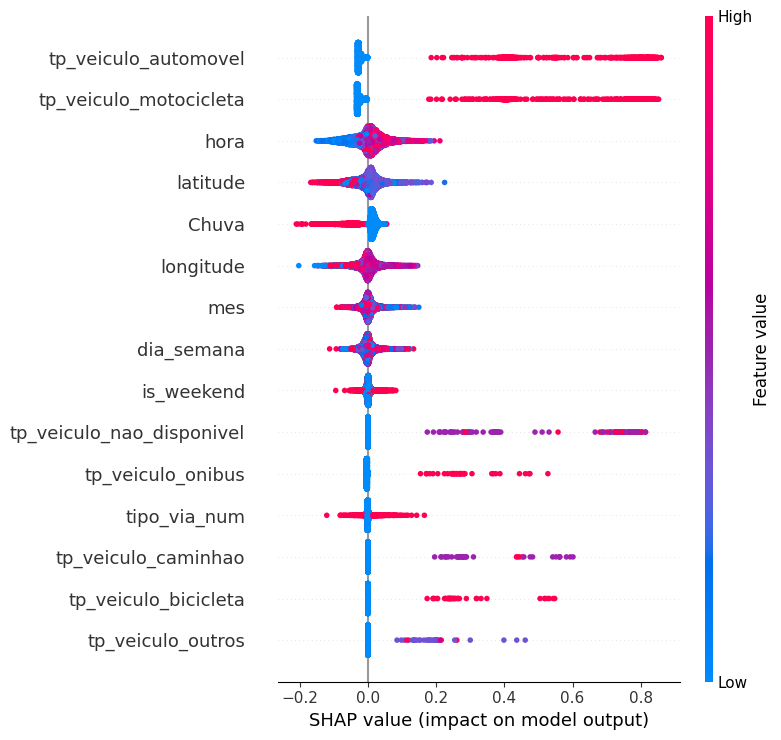

C:\Users\pirsp\AppData\Local\Temp\ipykernel_21692\1063239192.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", max_display=15, show=True)


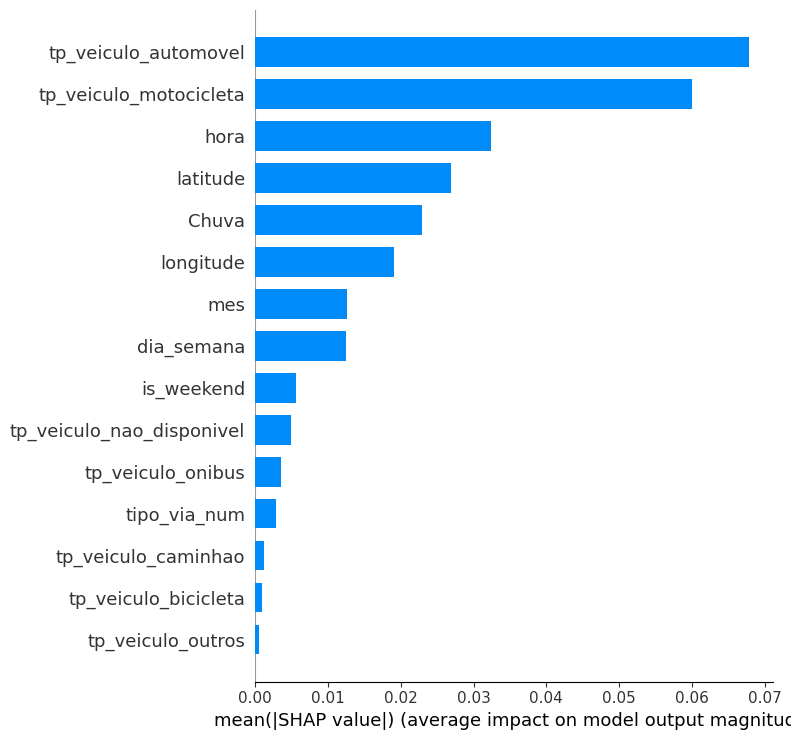

In [ ]:
explainer_rf = shap.TreeExplainer(final_rf_model)

# 2. Calcule os valores SHAP
#    (Nota: para modelos de árvore, pegamos o .values e selecionamos a classe 1)
shap_values_rf = explainer_rf(X_test)
shap_values_classe_1 = shap_values_rf.values[..., 1] 

print("Valores SHAP calculados.")

# 3. Plotar o gráfico de resumo
print("\nGráfico de Barras (Importância Geral):")
shap.summary_plot(
    shap_values_classe_1, 
    X_test, 
    plot_type="bar", 
    max_display=15, 
    show=True
)

print("\nGráfico Beeswarm (Impacto das Features):")
shap.summary_plot(
    shap_values_classe_1, 
    X_test, 
    max_display=15, 
    show=True
)

### Salvar o modelo

In [10]:
caminho_salvar_rf = 'src/model/modelo_risco_viario_RF.pkl'

joblib.dump(final_rf_model, caminho_salvar_rf)

['src/model/modelo_risco_viario_RF.pkl']